In [1]:
from kawin.Thermodynamics import MulticomponentThermodynamics
from kawin.KWNEuler import PrecipitateModel
from kawin.Surrogate import MulticomponentSurrogate, generateTrainingPoints
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

elements = ['NI', 'AL', 'CR']
phases = ['FCC_A1', 'FCC_L12']
therm = MulticomponentThermodynamics('NiCrAl.tdb', elements, phases)

t0, tf, steps = 1e-2, 1e6, 5000
model = PrecipitateModel(t0, tf, steps, elements=['AL', 'CR'])
print(model.minNucleateDensity)

model.setInitialComposition([0.098, 0.083])
model.setInterfacialEnergy(0.012)

T = 1073
model.setTemperature(T)

a = 0.352e-9
Va = a**3
Vb = Va
atomsPerCell = 4
model.setVaAlpha(Va, atomsPerCell)
model.setVaBeta(Vb, atomsPerCell)
print(model.VmAlpha)

#model.setNucleationSite('dislocations')
#model.setNucleationDensity(dislocationDensity=1e30)
model.setNucleationSite('bulk')
#model.setNucleationDensity(bulkN0 = 1e30)
model.setNucleationDensity(bulkN0 = 9.1717e28)

def secondMoment(model, p, i):
    return model.PBM[p].Moment(2)

model.addAdditionalOutput('area', secondMoment)
model.addAdditionalOutput('area', secondMoment)
model.addAdditionalOutput('area', secondMoment)
print(model.additionalFunctionNames)

1e-05
6.566119014400002e-06
['area' 'area_1' 'area_2']


In [2]:
import time
t0 = time.time()
surr = MulticomponentSurrogate(therm)

xAl = np.linspace(0.05, 0.11, 16)
xCr = np.linspace(0.05, 0.1, 16)
xTrain = generateTrainingPoints(xAl, xCr)
surr.trainDrivingForce(xTrain, T)

xAl = np.linspace(0.08, 0.23, 16)
xCr = np.linspace(0, 0.1, 16)
xTrain = generateTrainingPoints(xAl, xCr)
surr.trainCurvature(xTrain, T)

tf = time.time()
print('{:.3f}'.format(tf-t0))

model.setSurrogate(surr)

c:\Users\nury1\anaconda3\envs\reduced_base\lib\site-packages\pycalphad\core\utils.py:54: RuntimeWarning: invalid value encountered in divide
  pts[:, cur_idx:end_idx] /= pts[:, cur_idx:end_idx].sum(axis=1)[:, None]


12.623


In [3]:
model.solve(verbose=True, vIt=5000)
model.save('outputs//NiCrAl_TC')

N	Time (s)	Temperature (K)	AL	CR	
5000	1.6e+05		1073		9.1812	8.4757	

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	beta	6.414e+19		7.1640		6.0604e-08	2.5321e+00

Finished in 6.228 seconds.


In [ ]:
plt.style.use(['science', 'no-latex'])
plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(2, 2, figsize=(8,8))

modelLoad = PrecipitateModel.load('outputs//NiCrAl_TC.npz')

modelLoad.plot(axes[0,0], 'Precipitate Density', linewidth=2)
axes[0,0].set_ylim([1e10, 1e27])
axes[0,0].set_yscale('log')

#modelLoad.plot(axes[0,1], 'Composition', linewidth=2)
modelLoad.plot(axes[0,1], 'Volume Fraction', linewidth=2)
axes[0,1].set_ylim([6e-3, 2e0])
axes[0,1].set_yscale('log')
modelLoad.plot(axes[1,0], 'Average Radius', color='C0', linewidth=2, label='Avg. R')
modelLoad.plot(axes[1,0], 'Critical Radius', color='C1', linewidth=2, linestyle='--', label='R*')
axes[1,0].legend(loc='upper left')


#modelLoad.plot(axes[1,1], 'Size Distribution Density', linewidth=2, color='C0')
area = model.getAdditionalOutput('area')
axes[1,1].semilogx(model.time, area[0,:])

area2 = model.getAdditionalOutput('area_1')
axes[1,1].semilogx(model.time, area2[0,:])


axes[1,0].set_ylim([8e-11, 2e-6])
axes[1,0].set_yscale('log')

axes[0,0].set_xlim([4e-3, 2e6])
axes[1,0].set_xlim([4e-3, 2e6])
axes[0,1].set_xlim([4e-3, 2e6])

fig.tight_layout()
plt.show()

In [4]:
model.reset()
therm.clearCache()
model.setThermodynamics(therm)
model.solve(verbose=True, vIt=5000)
model.save('outputs//NiCrAl_TC_NoSurr')

N	Time (s)	Temperature (K)	AL	CR	
5000	3.7e+05		1073		8.7927	8.5730	

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	beta	4.653e+19		11.9324		7.9513e-08	1.9027e+00

Finished in 32.908 seconds.


In [ ]:
plt.style.use(['science', 'no-latex'])
plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(2, 2, figsize=(8,8))

modelLoad = PrecipitateModel.load('outputs//NiCrAl_TC_NoSurr.npz')

modelLoad.plot(axes[0,0], 'Precipitate Density', linewidth=2)
axes[0,0].set_ylim([1e10, 1e27])
axes[0,0].set_yscale('log')

#modelLoad.plot(axes[0,1], 'Composition', linewidth=2)
modelLoad.plot(axes[0,1], 'Volume Fraction', linewidth=2)
axes[0,1].set_ylim([6e-3, 2e0])
axes[0,1].set_yscale('log')
modelLoad.plot(axes[1,0], 'Average Radius', color='C0', linewidth=2, label='Avg. R')
modelLoad.plot(axes[1,0], 'Critical Radius', color='C1', linewidth=2, linestyle='--', label='R*')
axes[1,0].legend(loc='upper left')
modelLoad.plot(axes[1,1], 'Size Distribution Density', linewidth=2, color='C0')
axes[1,0].set_ylim([8e-11, 2e-6])
axes[1,0].set_yscale('log')

axes[0,0].set_xlim([4e-3, 2e6])
axes[1,0].set_xlim([4e-3, 2e6])
axes[0,1].set_xlim([4e-3, 2e6])

fig.tight_layout()
plt.show()

In [5]:
with open('outputs//NiCrAl_TCresults.csv', 'r') as file:
    lines = file.readlines()
    tn, n, tr, r, tv, v = [], [], [], [], [], []
    for l in range(1, len(lines)):
        data = lines[l].split(',')
        tn.append(float(data[0]))
        n.append(float(data[1]))
        tr.append(float(data[3]))
        r.append(float(data[4]))
        tv.append(float(data[6]))
        v.append(float(data[7]))

In [ ]:
plt.style.use(['science', 'no-latex'])
plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(1, 3, figsize=(15,4))

modelLoad = PrecipitateModel.load('outputs//NiCrAl_TC_NoSurr.npz')
modelSurr = PrecipitateModel.load('outputs//NiCrAl_TC.npz')

modelLoad.plot(axes[0], 'Precipitate Density', linewidth=2, label='kawin')
modelSurr.plot(axes[0], 'Precipitate Density', linewidth=2, label='kawin - Surrogate')
axes[0].plot(tn, n, label='TC Prisma')
expt = [14400, 57600, 230400, 950400]
expn = np.array([290, 68, 21, 7]) * 1e19
stdn = np.array([5, 1.1, 0.5, 0.13])*1e20
axes[0].scatter(expt, expn, color='k', s=24, label='Sudbrack et al')
#axes[0].errorbar(expt, expn, stdn, color='k', ms=0, fmt='o')
axes[0].set_ylim([1e10, 1e27])
axes[0].set_yscale('log')

modelLoad.plot(axes[1], 'Volume Fraction', linewidth=2, label='kawin')
modelSurr.plot(axes[1], 'Volume Fraction', linewidth=2, label='kawin - Surrogate')
axes[1].plot(tv, v, label='TC Prisma')
expv = [0.197, 0.19, 0.192]
stdv = [0.013, 0.03, 0.013]
axes[1].scatter(expt[1:], expv, color='k', s=24)
#axes[1].errorbar(expt[1:], expv, stdv, color='k', ms=0, fmt='o')
axes[1].set_ylim([6e-3, 2e0])
axes[1].set_yscale('log')

modelLoad.plot(axes[2], 'Average Radius', linewidth=2, label='kawin')
modelSurr.plot(axes[2], 'Average Radius', linewidth=2, label='kawin - Surrogate')
axes[2].plot(tr, r, label='TC Prisma')
expr = np.array([3.11, 5.8, 8.8, 14.]) * 1e-8
stdr = np.array([0.27, 0.5, 0.5, 1.5])*1e-8
axes[2].scatter(expt, expr, color='k', s=24, label='Sudbrack et al')
#axes[2].errorbar(expt, expr, stdr, color='k', ms=0, fmt='o')
axes[2].set_ylim([1e-10, 1e-6])
axes[2].set_yscale('log')

axes[0].legend()
axes[0].set_xlim([2e-3, 2e6])
axes[1].set_xlim([2e-3, 2e6])
axes[2].set_xlim([2e-3, 2e6])

fig.tight_layout()
plt.show()

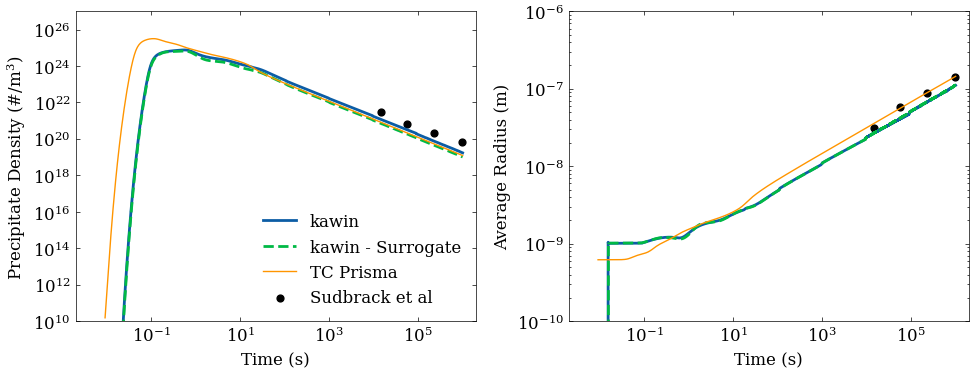

In [6]:
plt.style.use(['science', 'no-latex'])
plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(1, 2, figsize=(10,4))

modelLoad = PrecipitateModel.load('outputs//NiCrAl_TC_NoSurr.npz')
modelLoad2 = PrecipitateModel.load('outputs//NiCrAl_TC.npz')

modelLoad.plot(axes[0], 'Precipitate Density', linewidth=2, label='kawin')
modelLoad2.plot(axes[0], 'Precipitate Density', linewidth=2, linestyle='--', label='kawin - Surrogate')
axes[0].plot(tn, n, label='TC Prisma')
expt = [14400, 57600, 230400, 950400]
expn = np.array([290, 68, 21, 7]) * 1e19
stdn = np.array([5, 1.1, 0.5, 0.13])*1e20
axes[0].scatter(expt, expn, color='k', s=24, label='Sudbrack et al')
#axes[0].errorbar(expt, expn, stdn, color='k', ms=0, fmt='o')
axes[0].set_ylim([1e10, 1e27])
axes[0].set_yscale('log')

modelLoad.plot(axes[1], 'Average Radius', linewidth=2, label='kawin')
modelLoad2.plot(axes[1], 'Average Radius', linewidth=2, linestyle='--', label='kawin - Surrogate')
axes[1].plot(tr, r, label='TC Prisma')
expr = np.array([3.11, 5.8, 8.8, 14.]) * 1e-8
stdr = np.array([0.27, 0.5, 0.5, 1.5])*1e-8
axes[1].scatter(expt, expr, color='k', s=24, label='Sudbrack et al')
#axes[2].errorbar(expt, expr, stdr, color='k', ms=0, fmt='o')
axes[1].set_ylim([1e-10, 1e-6])
axes[1].set_yscale('log')

axes[0].legend()
axes[0].set_xlim([2e-3, 2e6])
axes[1].set_xlim([2e-3, 2e6])

fig.tight_layout()
plt.show()